In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/Users/meetpatel/Downloads/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


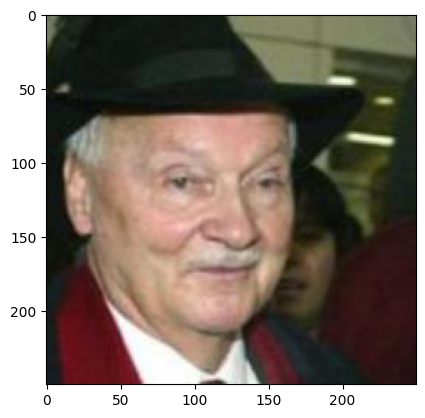

In [17]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

## Applications
#### AutoEncoders (AEs):
Dimensionality Reduction: Using nonlinear transformations, AEs are akin to PCA in their ability to reduce the dimensionality of data.

Feature Learning: They have the ability to acquire effective data representations, or encodings, that they can use as input for additional machine learning tasks.

Denoising: By teaching AEs to ignore the "noise" component in the input, noise can be eliminated from data.


#### Variational AutoEncoders (VAEs):
VAEs are capable of producing fresh data samples that closely resemble the training set, which is what makes them generative models. It is beneficial for creating images, producing music, and more.

Semi-Supervised Learning: Semi-supervised learning methods are suitable in situations where a limited amount of data has been labeled because of their probabilistic characteristics.

Interpolation: VAEs have the ability to smoothly interpolate within the latent space between different classes or examples, which renders them valuable in a multitude of creative contexts.

## Architecture
#### AutoEncoders:
Consist of two main components: an encoder that compresses the input into a latent-space representation, and a decoder that reconstructs the input from this representation.

The architecture is deterministic, meaning for a given input, the output is always the same.
#### Variational AutoEncoders:
Feature a decoder and an encoder as well, but a VAE's encoder maps inputs into a distribution throughout the latent space as opposed to a single point.Instead,

The encoding process is made stochastic by VAEs, which add a stochastic element. A latent vector sample is obtained from the encoder's parameters, which are sent to a probability distribution (usually a Gaussian).Instead,

## Loss Function
#### AutoEncoders:
Reconstruction loss, which gauges how well the decoder can reconstruct the input data from the latent representation, usually makes up the loss function.

When dealing with continuous input data, the Mean Squared Error (MSE) or Binary Cross-Entropy (BCE) are popular alternatives for the reconstruction loss.

#### Variational AutoEncoders:
In order to make sure the decoded samples match the original inputs, VAEs also employ reconstruction losses.

They also incorporate a regularizer on the latent space representation, which is usually the Kullback-Leibler (KL) divergence between the distribution of the encoder and a previous distribution, which is usually a standard Gaussian distribution. This concept avoids overfitting by encouraging the model to learn effective and organized latent areas.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        # Initialize encoder layers
        self.enc_conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Correct the size for mean and log variance layers
        self.fc_mu = nn.Linear(in_features=65536, out_features=10)  # Adjusted to match the flattened size
        self.fc_logvar = nn.Linear(in_features=65536, out_features=10)
        self.dec_fc = nn.Linear(10, 65536)

        # Initialize decoder layers
        self.dec_conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_bn2 = nn.BatchNorm2d(16)
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        x = torch.flatten(x, start_dim=1)  # Flatten the output for the linear layers
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = self.dec_fc(z)
        z = z.view(-1, 64, 32, 32)  # Reshape to match the encoder output
        x = F.relu(self.dec_bn1(self.dec_conv1(z)))
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = torch.sigmoid(self.dec_conv3(x))
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)
        return x

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

The encoder in a VAE compresses the input data into a latent space representation. In our VAE, this representation is characterized by two components: mu (mean) and logvar (log variance). These components define a Gaussian distribution in the latent space from which we can sample.

In [10]:
image = torch.randn(1, 3, 250, 250) 
vae = VAE()

# Pass a random image through the VAE
reconstructed_image, mu, logvar = vae(image)

# Print the shapes of the mean (mu) and log variance (logvar)
print("Shape of mu (mean):", mu.shape)
print("Shape of logvar (log variance):", logvar.shape)
print("Shape of reconstructed image:", reconstructed_image.shape)


Shape of mu (mean): torch.Size([1, 10])
Shape of logvar (log variance): torch.Size([1, 10])
Shape of reconstructed image: torch.Size([1, 3, 250, 250])


To generate new samples, we utilize the properties of the Gaussian distribution defined by mu and logvar. The process involves the following steps:

#### The Reparameterization Trick: 
It keeps the network differentiable (and so trainable through backpropagation), allowing us to sample from the latent space. Next, we add random noise (eps) scaled by the standard deviation (std) to the mean (mu) after calculating the standard deviation (std) from the logvar. Thus, a new latent vector z is created.

#### Sampling:
The Gaussian distribution in the latent space is essentially sampled by the new latent vector z. Various samples can capture distinct features of the data distribution because they correspond to various points in the latent space.



In [11]:
# Calculate standard deviation from log variance
std = torch.exp(0.5 * logvar)

# Generate random noise
eps = torch.randn_like(std)

# Create a new latent space vector (z)
z = mu + eps * std

The decoder part of the VAE takes the sampled latent vector z and reconstructs it back into data space (e.g., an image). This is how new data samples are generated.

In [12]:
# Decode the sampled latent vector to generate a new image
new_image = vae.decoder(z)

# Print the shape of the new image
print("Shape of the generated image:", new_image.shape)


Shape of the generated image: torch.Size([1, 3, 250, 250])


The encoder in a VAE converts the input data to a distribution in the hidden space. We can create additional data points by taking a sample from this space. Subsequently, the decoder utilizes these samples and reconstructs them into the original data space. This method demonstrates the strength of the VAE as a generative model by enabling it to produce new, similar data points in addition to learning a compact representation of the input. The new image, mu, and logvar shapes verify the size of our latent space and the reconstructed output, respectively, suggesting that the forward pass of the VAE is operating as planned.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
* create an optimizer for training


In [14]:
# Loss Function
reconstruction_loss = torch.nn.MSELoss()  
kl_divergence_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

# Calculate the total number of parameters
total_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print("Total number of parameters:", total_params)


Total number of parameters: 2079063


## Loss Function in VAEs
A VAE's loss function comprises two primary components:

### Reconstruction Loss:
##### Purpose: 
This part assesses the VAE's ability to use its latent space representation to reconstruct the input data. Ensuring that the VAE effectively learns to encode and then decode the input data is the aim.
##### How it Works: 
The reconstruction loss is calculated by comparing the decoder's reconstructed output data with the original input data. The difference or error between them is quantified.

##### Types:
Mean Squared Error Loss is the function torch.nn.MSELoss(), which is used with continuous data. The difference between the estimator and the estimated value is measured by averaging the squares of the errors or deviations.

Usually applied to binary or categorical data, torch.nn.BCELoss() returns the Binary Cross-Entropy Loss. It calculates how different two probability distributions—the distribution of the actual data and the distribution predicted by the model—are from one another.
### KL Divergence Loss:
<b> Purpose:</b> 
This part penalizes divergences from a prior distribution (typically a standard normal distribution) in the latent space, thereby regularizing the VAE. It helps to generalize the model and prevent overfitting by ensuring that the distribution of the latent variables doesn't deviate too much from the prior.

<b>How it Works:</b> The degree to which one probability distribution—the one generated by the encoder—dives from a second, expected probability distribution—the prior—is measured by the Kullback-Leibler (KL) divergence. This divergence is calculated using the formula -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()). In essence, it calculates the deviation between the assumed normal distribution and the encoder's output distribution, which is determined by logvar and mu.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
vae = vae.to(device)

# Adjust the learning rate
optimizer = torch.optim.Adam(vae.parameters(), lr=0.0001)

clip_value = 1.0  
num_epochs= 10

for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device) 

        # Forward pass
        reconstructed, mu, logvar = vae(x)

        # Compute losses
        recon_loss = reconstruction_loss(reconstructed, x)
        kl_loss = kl_divergence_loss(mu, logvar)
        loss = recon_loss + kl_loss

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(vae.parameters(), clip_value)

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 21.1220
Epoch [2/10], Loss: 4.5871
Epoch [3/10], Loss: 3.7080
Epoch [4/10], Loss: 2.6261
Epoch [5/10], Loss: 1.9600
Epoch [6/10], Loss: 1.5526
Epoch [7/10], Loss: 1.1079
Epoch [8/10], Loss: 0.7096
Epoch [9/10], Loss: 0.5567
Epoch [10/10], Loss: 0.2798


Here are six essential points to consider when the loss is not decreasing during the training of a Variational AutoEncoder (VAE):<br>

1. <b> Changing the Learning Rate:</b> A model may overshoot the minimum if the learning rate is too high, and it may converge slowly or not at all if it is too low. Try out various learning rates to determine the best one.

2. <b>Analyze the Model Architecture:</b> Make sure the model is appropriate for the data, neither too complex nor too simple. If necessary, change the number of layers and neurons per layer or think about incorporating regularization strategies like dropout.

3. <b>Verify Data Preprocessing:</b> It's important to preprocess properly. This entails appropriately normalizing input data and making sure it is free of errors like outliers or incorrect labeling that could confuse the training process.

4. <b>Parts of Balance Loss:</b> Reconstruction loss plus KL divergence add up to the total loss in VAEs. The performance of the model can be greatly affected by changing the ratio between these two elements.
    
5. <b>Track Underfitting and Overfitting:</b> Overfitting of the model will result in good performance on training data but poor performance on unseen data. Additional data, data augmentation, or regularization can be helpful. Consider making the model more complex or prolonging the training period to address underfitting.

6. <b>Make Use of a Learning Rate Scheduler:</b> By putting in place a learning rate scheduler, training participants can modify their learning rate, potentially leading to improved convergence.


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

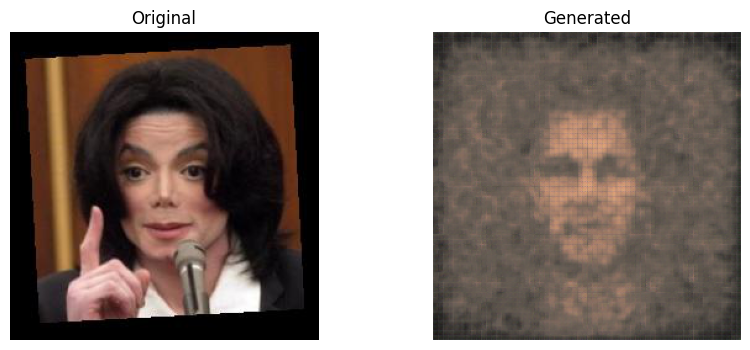

In [60]:
# Assuming the generate_sample function is defined as follows
def generate_sample(model, latent_dim, device):
    # Correct latent_dim to match the model's expected input size
    correct_latent_dim = 10  # Adjust this to match your VAE's architecture
    z = torch.randn(1, correct_latent_dim).to(device)
    with torch.no_grad():
        generated_image = model.decoder(z)
    return generated_image


# Instance name of your model is 'vae'
latent_dim = 30 

# Select a random image from the dataset
dataiter = iter(dataloader)
images, labels = next(dataiter)
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index].to(device) 

# Generate a single image
vae.eval()  # Set the model to evaluation mode
generated_image = generate_sample(vae, latent_dim, device)

# Convert images to numpy for plotting
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
generated_image_np = generated_image.squeeze().permute(1, 2, 0).cpu().numpy()

# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(generated_image_np)
plt.title("Generated")
plt.axis('off')

plt.show()